# Char-RNN Implementation (sequence-to-sequence model)

## Description:
We code up the [char-rnn model of Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). This is a recurrent neural network that is trained probabilistically on sequences of characters, and that can then be used to sample new sequences that are like the original.

## There are two parts of this lab:
###  1.   Wiring up a basic sequence-to-sequence computation graph
###  2.   Implementing custom GRU cell.


An example of some final samples from an equivalent implementation are shown below (more detail in the
final section of this writeup), after 150 passes through the data.
We generate about 15 samples for each dataset.

<code>
And ifte thin forgision forward thene over up to a fear not your
And freitions, which is great God. Behold these are the loss sub
And ache with the Lord hath bloes, which was done to the holy Gr
And appeicis arm vinimonahites strong in name, to doth piseling 
And miniquithers these words, he commanded order not; neither sa
And min for many would happine even to the earth, to said unto m
And mie first be traditions? Behold, you, because it was a sound
And from tike ended the Lamanites had administered, and I say bi
</code>


In [ ]:
# ! wget -O ./text_files.tar.gz 'https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz' 
# ! tar -xzf text_files.tar.gz
# ! pip install unidecode
# ! pip install torch

import unidecode
import string
import random
import re
 
import pdb
 
all_characters = string.printable
n_characters = len(all_characters)
# file = unidecode.unidecode(open('./text_files/lotr.txt').read())
# file_len = len(file)
# print('file_len =', file_len)

CUDA_LAUNCH_BLOCKING=1

In [ ]:
from google.colab import files
import io
def upload():
  print('Upload Text')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path

content_path_text = upload()

Upload Text


Saving christmas_carol.txt to christmas_carol (12).txt


In [ ]:
file = content_path_text.read()
file = str(file).replace("\\r\\n",'\n')
file = unidecode.unidecode(file)
file_len = len(file)
print('file_len =', file_len)

file_len = 178293


In [ ]:
chunk_len = 200
 
def random_chunk():
  start_index = random.randint(0, file_len - chunk_len)
  end_index = start_index + chunk_len + 1
  return file[start_index:end_index]
  
print(random_chunk())

arth swept, and the fire made up. The compound in the
jug being tasted, and considered perfect, apples and oranges
were put upon the table, and a shovel-full of chestnuts on the
fire. Then all the Crat


In [ ]:
import torch
from torch.autograd import Variable
# Turn string into list of longs
def char_tensor(string):
  tensor = torch.zeros(len(string)).long() #FIXME: CUDA?
  for c in range(len(string)):
      tensor[c] = all_characters.index(string[c])
  return Variable(tensor.cuda())

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41], device='cuda:0')


---

## Creating our own GRU cell 

---

We write our own GRU class using the same parameters as the built-in Pytorch class does.



In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter


class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(GRU, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    
    self.lin_ir = nn.Linear(input_size, hidden_size).cuda()
    self.lin_hr = nn.Linear(hidden_size, hidden_size).cuda()
    self.lin_iz = nn.Linear(input_size, hidden_size).cuda()
    self.lin_hz = nn.Linear(hidden_size, hidden_size).cuda()
    self.lin_in = nn.Linear(input_size, hidden_size).cuda()
    self.lin_hn = nn.Linear(hidden_size, hidden_size).cuda()
  
  def forward(self, inputs, hidden):
    # Each layer does the following:
    # r_t = sigmoid(W_ir*x_t + b_ir + W_hr*h_(t-1) + b_hr)
    # z_t = sigmoid(W_iz*x_t + b_iz + W_hz*h_(t-1) + b_hz)
    # n_t = tanh(W_in*x_t + b_in + r_t**(W_hn*h_(t-1) + b_hn))
    # h_(t) = (1 - z_t)**n_t + z_t**h_(t-1)
    # Where ** is hadamard product (not matrix multiplication, but elementwise multiplication)
    
    # We are at time 0
    x = inputs.cuda()
    h = hidden.cuda()
#     h_s = h
    r = torch.sigmoid(self.lin_ir(x) + self.lin_hr(h)).cuda()
    z = torch.sigmoid(self.lin_iz(x) + self.lin_hz(h)).cuda()
    n = torch.tanh(self.lin_in(x) + r*self.lin_hn(h)).cuda()
    h = (1-z)*n + z*h  
#       x = h
#       hs = torch.cat(hs,h,dim=1)
    
    outputs = h.cuda()
    hiddens = h.cuda()
    return outputs, hiddens
  
# Embeddings model 

  


---

##  Building a sequence to sequence model

---

Great! We have the data in a useable form. We can switch out which text file we are reading from, and trying to simulate.

We now want to build out an RNN model, in this section, we will use all built in Pytorch pieces when building our RNN class.




In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, dim_vocab, n_layers=1):
    super(RNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.dim_vocab = dim_vocab
    self.n_layers = n_layers
    
#     self.W_hh = nn.Linear(hidden_size,hidden_size)
#     self.W_xh = nn.Linear(input_size,hidden_size)
#     self.W_hy = nn.Linear(hidden_size,output_size)
    
    self.embedding = nn.Embedding(input_size, dim_vocab).cuda()
    self.gru = GRU(input_size, hidden_size, n_layers)# nn.GRU(input_size=dim_vocab, hidden_size=hidden_size, num_layers=n_layers).cuda()
    self.lin = nn.Linear(hidden_size, output_size).cuda() # 

  def forward(self, inp, hidden):
    # by reviewing the documentation, construct a forward function that properly uses the output
    # of the GRU
    embedded = self.embedding(inp).view(1, 1, -1)
#     print("Yo embed yo")
    embedded = F.relu(embedded.cuda())
#     pdb.set_trace() # Good spot to de-bug
    for t in range(self.n_layers):
      out, hidden = self.gru(embedded, hidden)
      out = self.lin(out[0])
      embedded = F.relu(out.cuda())
    
    return out, hidden

  def init_hidden(self):
    return Variable(torch.zeros(self.n_layers, 1, self.hidden_size).cuda())

In [ ]:
def random_training_set(): 
  """ This fcn returns two tensors that are our encoded tokens (but not embedded)
  """
  chunk = random_chunk()
  chunk = chunk.replace("\\r\\n",'\n')
#   pdb.set_trace()
  inp = char_tensor(chunk[:-1]) # What we put in (all but last char)

  target = char_tensor(chunk[1:]) # What we hope to get out (from second to last char)
  return inp, target

In [ ]:
i,t=random_training_set()
len(i)

200

---

## Sample text and Training information

---

We now want to be able to train our network, and sample text after training.

This function outlines how training a sequence style network goes. 





In [ ]:
# hidden_size_default = 200 # This is the dimension of our embedding space
# It's a hyper-parameter that we can tune as we like


def train(inp, target):
  """ 
  Parameters:
    both are token-tensors generated by the char_tensor fcn
      (and returned by the random_training_set fcn)
  """
  ## initialize hidden layers, set up gradient and loss 
  
  decoder_optimizer.zero_grad()
  hidden = decoder.init_hidden()
  loss = 0
  
  # more stuff here...
  for inp_char, target_char in zip(inp,target):
    y_hat, hidden = decoder.forward(inp_char,hidden) # Note: y_hat is like a prob'ty dist'n
    target_char = target_char.unsqueeze(0) # Note: target_char is like an integer
    loss += criterion(y_hat, target_char)
  
  loss.backward()
  decoder_optimizer.step()
  
  return loss
  
  
  

---

## Sample text and Training information

---




In [ ]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
  ## initialize hidden variable, initialize other useful variables 
  # Get an initial hidden state 
  hidden = decoder.init_hidden()
  list_of_tokens = [char for char in prime_str]
  
  for char in prime_str:
    inp = char_tensor(prime_str[-1])
    out_vec, hidden = decoder.forward(inp,hidden)
  
  # Take the final out_vec and calculate the char from it 
  out = torch.multinomial(out_vec/sum(out_vec), 1)
  list_of_tokens.append(all_characters[int(out)])
  
  # Now we take that output char and keep generating based on that
  inp = Variable( out.long().cuda() )
  for _ in range(predict_len-1):
    # Find a tensor token to pass through the model
    out_vec, hidden = decoder.forward(inp,hidden)
    
    # Now let's get the out_vec to look like a probability dist'n
    out_vec = softmax( torch.exp(out_vec/temperature) )
    # Convert to a single number by sampling
    out = torch.multinomial(out_vec, 1)
    # Append to the list 
    list_of_tokens.append(all_characters[int(out)])
    # Update
    inp = Variable( out.long() )
    
  return ''.join(list_of_tokens)
  ## /
  


---

## Run it and generate some text!

---

Assuming everything has gone well, you should be able to run the main function in the scaffold code, using either your custom GRU cell or the built in layer, and see output something like this. Using chunk_length=200, hidden_size=100 for 2000 epochs gave.



In [ ]:
import time
n_epochs = 4000 # 5000
print_every = 200
plot_every = 10
hidden_size = 400
n_layers = 1
dim_vocab = 100
logsoftmax = nn.LogSoftmax(dim=1)
softmax = nn.Softmax(dim=1)
lr = 0.001
 
decoder = RNN(n_characters, hidden_size, n_characters, dim_vocab=dim_vocab, n_layers=n_layers)
decoder.cuda()
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss().cuda()
 
start = time.time()
all_losses = []
loss_avg = 0

In [ ]:
evaluate()

'AK4KBh(JOn?p+Tt0\r++P^ho\\mplP*=U\rQZ<>zL `z<ZCc\x0bC\tKG_Wp*NBi*Lwsg.@<x42?bqhq5xUy|\rs&|H >#/A7X Z\tA>\x0b%Bk\\5'

In [ ]:
emb_test = nn.Embedding(n_characters, dim_vocab).cuda()
embd = emb_test(char_tensor("A")).view(1, 1, -1)
embdF = F.relu(embd)
embdF.size()

torch.Size([1, 1, 100])

In [ ]:
# n_epochs = 2000
for epoch in range(1, n_epochs + 1):
  loss_ = train(*random_training_set()) # Note we're passing two token tensors through train     
  loss_avg += loss_

  if epoch % print_every == 0:
      print('[%s s (epoch %d %d%%) %.4f]' % (time.time() - start, epoch, epoch / n_epochs * 100, loss_/100.))
      eval_str = evaluate('Wh',temperature=.2).replace('\n','\\n')
      print(eval_str, '\n')

  if epoch % plot_every == 0:
      all_losses.append(loss_avg / plot_every)
      loss_avg = 0

[104.2055287361145 s (epoch 200 5%) 4.4141]
WhH the was the was the was the was the was the was the was the was the was the was the was the was th 

[208.13289618492126 s (epoch 400 10%) 3.8675]
WhX his his his his his his his his his his his his his his his his his his his his his his his his hi 

[311.93042945861816 s (epoch 600 15%) 3.8104]
WhAr so down and the was the could the was the was the was the was the could the was the was the was t 

[416.06379318237305 s (epoch 800 20%) 3.4703]
Wh: said Scrooge and stoped the children and stoped the children and stoped the children and stoped th 

[519.8927199840546 s (epoch 1000 25%) 3.3508]
WhZre to the wasted the wasted the wasted the\nwasted the wasted the wasted the wasted the wasted the\nw 

[624.4934210777283 s (epoch 1200 30%) 3.1558]
Wh2us a should have been a should\nhave been a sure and street in the was a see and stoped the was a sh 

[728.4678494930267 s (epoch 1400 35%) 3.2303]
Wh0ing and state as the was the was the was the

tensor(748.4874)


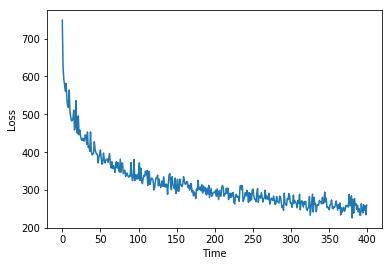

In [ ]:
CUDA_LAUNCH_BLOCKING=1
from matplotlib import pyplot as plt
print(all_losses[0].cpu().detach())
plt.plot(all_losses)
plt.ylabel("Loss")
plt.xlabel("Time")
plt.show()

In [ ]:
for i in range(10):
  start_strings = [" Th", " wh", " he", " I ", " ca", " G", " lo", " ra"]
  start = random.randint(0,len(start_strings)-1)
  print(start_strings[start])
#   all_characters.index(string[c])
  print(evaluate(start_strings[start], predict_len=200, temperature=2).replace('\n','\\n'), '\n')

 lo
 lo.\n\n"I will you see here it is not the Ghost, "you don\'t know what it was a laugh. It\'s a great faith and many you have good a laugh. It was not a short, and he said, on it, you see him was his own,  

 ra
 raR and hope you see him was his own, to say\na long as he said, and so looked at the fire, and having the strong on the strong one of the strong one of the things the door, and\nstood out with a moment y 

 ca
 caed in the strong on the moment,\nthe same of the strong on the town, or one of the family. The more he did so\nmany coated on the office in the strong on the fire of which it was not a short,\nfor the f 

 ca
 caE |an you have been down at his own at the hungry\nchange and hope you see him was his own at the strong one of the strong on the hallow\nhe had not below his head. It was a shool of the moment,\nthe one 

 ra
 ra`ed to his face was not a large and happier of the moment,\nthe spont. "I have not to be not a heavy some off in!"\n\nScrooge had a short of th

The model does well in general. Loss went down over time. It's great at making English words, but not coherent sentences. Most of these are major word repetitions. As you can see, increasing the temperature to 2 yields much nicer, Dickens-like sentences than we saw printed during training.